In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd
from metrics import testMLModel

In [17]:
df = pd.read_csv("archive/clean_IMDB3.csv")

In [18]:
X = df["clean_review"]
y = df["sentiment"].map({"positive":1, "negative":0})

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [25]:
pipe_svc = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("clf", LinearSVC(random_state=42))
])

In [26]:
param_grid_svc = {
    "tfidf__max_features": [20000, 40000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "clf__C": [0.5, 1.0, 2.0, 4.0],
    "clf__class_weight": [None, "balanced"]
}

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
grid_svc = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid_svc,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

In [29]:
grid_svc.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__C': [0.5, 1.0, ...], 'clf__class_weight': [None, 'balanced'], 'tfidf__max_features': [20000, 40000], 'tfidf__min_df': [1, 2], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [30]:
print("SVC - Best params:", grid_svc.best_params_)
print("SVC - CV best score:", grid_svc.best_score_)
best_svc = grid_svc.best_estimator_

SVC - Best params: {'clf__C': 0.5, 'clf__class_weight': None, 'tfidf__max_features': 40000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
SVC - CV best score: 0.8991


In [32]:
y_pred = best_svc.predict(X_test)


===  : Rapport de classification ===
              precision    recall  f1-score   support

           0     0.9111    0.8954    0.9032      5000
           1     0.8972    0.9126    0.9048      5000

    accuracy                         0.9040     10000
   macro avg     0.9041    0.9040    0.9040     10000
weighted avg     0.9041    0.9040    0.9040     10000

===  : Matrice de confusion ===


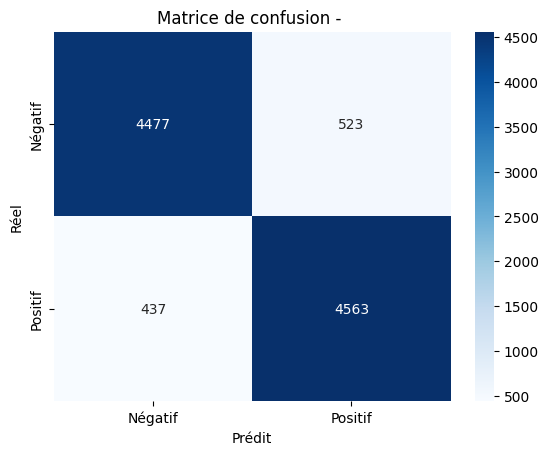

===  : Courbe d'apprentissage (accuracy) ===


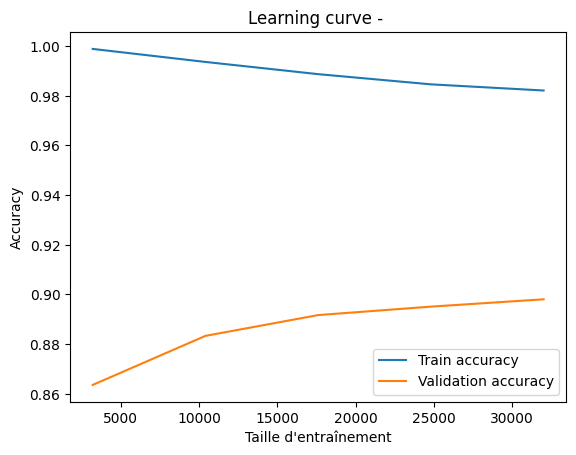

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

RANDOM_STATE = 42

title = ""

print(f"\n=== {title} : Rapport de classification ===")
print(classification_report(y_test, y_pred, digits=4))

# Matrice de confusion
print(f"=== {title} : Matrice de confusion ===")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Négatif","Positif"],
            yticklabels=["Négatif","Positif"])
plt.xlabel("Prédit"); plt.ylabel("Réel"); plt.title(f"Matrice de confusion - {title}")
plt.show()

# Courbe d'apprentissage (Accuracy)
print(f"=== {title} : Courbe d'apprentissage (accuracy) ===")
train_sizes, train_scores, test_scores = learning_curve(
    best_svc, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1, random_state=RANDOM_STATE
)
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train accuracy")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation accuracy")
plt.xlabel("Taille d'entraînement"); plt.ylabel("Accuracy"); plt.title(f"Learning curve - {title}")
plt.legend(); plt.show()

In [41]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(best_svc,X,y)

In [43]:
print(score)
print(score.mean())

[0.9065 0.9027 0.9012 0.8973 0.9002]
0.90158


In [44]:
import joblib

joblib.dump(best_svc,"modelSVCV0.pkl")
joblib.dump(grid_svc,"gridForSVCV0.pkl")

['gridForSVCV0.pkl']